Установка необходимых библиотек

In [2]:

%pip install boto3
%pip install python-dotenv
%pip install newsapi-python
%pip install textblob
%pip install vaderSentiment
%pip install spacy
%pip install fuzzywuzzy
%pip install python-Levenshtein
%pip install yfinance
%pip install joblib
%pip install torch torchvision torchaudio
%pip install --upgrade torch
%pip install jupyter
%pip install matplotlib
%pip install scikit-learn
%pip install tensorboard
%pip install seaborn



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

Загрузка модели spaCy

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.7 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Импорт библиотек и настройка визуализации

In [4]:
# Импорт стандартных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Импорт библиотек для работы с AWS и DynamoDB
import boto3
from dotenv import load_dotenv

# Импорт библиотек для обработки текста и анализа настроений
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from fuzzywuzzy import process

# Импорт библиотек для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Импорт PyTorch для построения модели LSTM
import torch
import torch.nn as nn
from torch.autograd import Variable
import joblib

# Настройка визуализации
# plt.style.use('seaborn')
plt.style.use("seaborn-v0_8")
%matplotlib inline

# Загрузка модели spaCy
nlp = spacy.load("en_core_web_sm")


.env uploads

In [31]:
from dotenv import load_dotenv
from pathlib import Path

# Загрузка переменных окружения из .env файла
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)


True

files company

In [32]:
with open('companies.json', 'r') as f:
    COMPANIES = json.load(f)

Функция для извлечения новостей из DynamoDB

In [33]:
def fetch_news_data():
    try:
        # Инициализация клиента STS
        sts_client = boto3.client('sts', region_name=os.getenv('AWS_REGION'))
        
        assumed_role = sts_client.assume_role(
            RoleArn=os.getenv('ROLE_ARN'),  # ARN вашей роли STS
            RoleSessionName='LocalNewsAnalyzerSession'
        )
        
        credentials = assumed_role['Credentials']
        
        # Инициализация клиента DynamoDB с временными креденшиалами
        dynamodb = boto3.resource(
            'dynamodb',
            region_name=os.getenv('AWS_REGION'),
            aws_access_key_id=credentials['AccessKeyId'],
            aws_secret_access_key=credentials['SecretAccessKey'],
            aws_session_token=credentials['SessionToken']
        )
        
        table = dynamodb.Table(os.getenv('DYNAMODB_TABLE'))
        
        # Сканирование всей таблицы (для больших таблиц рекомендуется использовать пагинацию)
        response = table.scan()
        items = response.get('Items', [])
        
        # Преобразование данных в DataFrame
        news_df = pd.DataFrame(items)
        
        # Преобразование типов данных
        news_df['textblob_sentiment'] = news_df['textblob_sentiment'].apply(lambda x: float(x))
        news_df['vader_sentiment'] = news_df['vader_sentiment'].apply(lambda x: float(x)) if 'vader_sentiment' in news_df.columns else 0.0
        news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'])
        
        return news_df
    
    except Exception as e:
        print(f"Ошибка при извлечении данных из DynamoDB: {e}")
        return pd.DataFrame()  # Возвращаем пустой DataFrame в случае ошибки


Функция для получения исторических данных о ценах акций с помощью yfinance

In [34]:
import yfinance as yf

def get_stock_data(ticker, start_date='2015-01-02', end_date='2024-10-04'):
    """
    Получает исторические данные о ценах акций для заданного тикера.
    
    :param ticker: Тикер акции (например, 'AAPL' для Apple)
    :param start_date: Начальная дата в формате 'YYYY-MM-DD'
    :param end_date: Конечная дата в формате 'YYYY-MM-DD'
    :return: DataFrame с историческими данными о ценах акций
    """
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)
    hist.reset_index(inplace=True)
    hist['Date'] = hist['Date'].dt.date
    hist = hist[['Date', 'Close']]
    return hist


Подготовка и объединение данных

In [35]:
def prepare_data(news_df, stock_df):
    # Преобразование publishedAt в дату
    news_df['published_date'] = news_df['publishedAt'].dt.date
    
    # Группировка настроений по дате
    sentiment_daily = news_df.groupby('published_date')[['textblob_sentiment', 'vader_sentiment']].mean().reset_index()
    sentiment_daily.rename(columns={'published_date': 'Date'}, inplace=True)
    
    # Подготовка данных о ценах акций
    stock_df.rename(columns={'Date': 'Date', 'Close': 'Close'}, inplace=True)
    
    # Объединение данных по дате
    merged_df = pd.merge(sentiment_daily, stock_df, on='Date', how='inner')
    merged_df = merged_df.dropna()
    
    return merged_df


Определение модели LSTM с использованием PyTorch

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Определение слоя LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Полносвязный слой
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Инициализация скрытых и ядерных состояний
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()

        # Пропуск через LSTM слой
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Пропуск через полносвязный слой
        out = self.fc(out[:, -1, :]) 
        return out


Загрузка и подготовка данных

In [37]:
# Извлечение данных из DynamoDB
news_df = fetch_news_data()
if news_df.empty:
    print("Нет данных для анализа.")
else:
    print("Данные о новостях успешно загружены.")
    display(news_df.head())


Данные о новостях успешно загружены.


,company,publishedAt,headline,source,description,url,textblob_sentiment,author,vader_sentiment
0,First Trust NASDAQ Rising Dividend Achievers,2024-10-03 19:40:28+00:00,Innovation Pharmaceuticals (OTCMKTS:IPIX) & Cu...,ETF Daily News,CureVac (NASDAQ:CVAC – Get Free Report) and In...,https://www.etfdailynews.com/2024/10/03/innova...,0.375000,MarketBeat News,0.9343
1,Organigram,2024-10-04 07:25:02+00:00,GAN (NASDAQ:GAN) & HUYA (NYSE:HUYA) Head to He...,ETF Daily News,HUYA (NYSE:HUYA – Get Free Report) and GAN (NA...,https://www.etfdailynews.com/2024/10/04/gan-na...,0.500000,MarketBeat News,0.9239
2,First Trust NASDAQ Rising Dividend Achievers,2024-10-03 12:30:04+00:00,EuroSite Power (OTCMKTS:EUSP) & MGE Energy (NA...,ETF Daily News,MGE Energy (NASDAQ:MGEE – Get Free Report) and...,https://www.etfdailynews.com/2024/10/03/eurosi...,0.433333,MarketBeat News,0.9186
3,Unknown,2024-10-04 03:08:05+00:00,Rajiv Jain is unimpressed by China stock mania...,The Times of India,he manager of the top-performing $23 billion G...,https://economictimes.indiatimes.com/markets/s...,-0.083333,Bloomberg,0.0000
4,First Trust NASDAQ Rising Dividend Achievers,2024-10-04 05:56:58+00:00,Critical Survey: RumbleOn (NASDAQ:RMBL) vs. CI...,ETF Daily News,CI&T (NYSE:CINT – Get Free Report) and RumbleO...,https://www.etfdailynews.com/2024/10/04/critic...,0.433333,MarketBeat News,0.9091


Получение данных о ценах акций

In [38]:
# Выберите тикеры, которые вы хотите проанализировать
tickers = ['AAPL', 'GOOG', 'IBM']  # Добавьте другие тикеры по мере необходимости

# Получение данных о ценах акций для каждого тикера
stock_data = {}
for ticker in tickers:
    stock_df = get_stock_data(ticker)
    stock_data[ticker] = stock_df
    print(f"Данные о {ticker} успешно загружены.")

Данные о AAPL успешно загружены.
Данные о GOOG успешно загружены.
Данные о IBM успешно загружены.


Подготовка данных для модели

In [39]:
# Выберите тикер для анализа (например, 'AAPL')
selected_ticker = 'AAPL'
stock_df = stock_data[selected_ticker]

# Подготовка данных
merged_df = prepare_data(news_df, stock_df)
print("Объединенные данные:")
display(merged_df.head())


Объединенные данные:


,Date,textblob_sentiment,vader_sentiment,Close
0,2024-10-02,0.374277,0.779710,226.779999
1,2024-10-03,0.306701,0.705984,225.669998


Масштабирование данных

In [19]:
# Инициализация масштабатора
scaler = MinMaxScaler(feature_range=(-1, 1))

# Масштабирование данных
scaled_data = scaler.fit_transform(merged_df[['textblob_sentiment', 'vader_sentiment', 'Close']])

# Преобразование обратно в DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['textblob_sentiment', 'vader_sentiment', 'Close'])


Создание обучающих и тестовых выборок

In [48]:
# def create_sequences(data, look_back=60):
#     X = []
#     y = []
#     for i in range(len(data) - look_back):
#         seq = data[i:i + look_back][['textblob_sentiment', 'vader_sentiment']].values
#         target = data.iloc[i + look_back]['Close']
#         print(f'Sequence {i}: {seq}, Target: {target}')  # Debug output
#         X.append(seq)
#         y.append(target)
#     X = np.array(X)
#     y = np.array(y)
#     return X, y



# look_back = 60
# X, y = create_sequences(scaled_df, look_back)

# print(f'X shape: {X.shape}, y shape: {y.shape}')

# # Разделение на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # print(scaled_df.head())
# # print(scaled_df.shape)


# # print(f'X_train shape: {X_train.shape}')
# # print(f'y_train shape: {y_train.shape}')
# # print(f'X_test shape: {X_test.shape}')
# # print(f'y_test shape: {y_test.shape}')
print(scaled_df.shape)
print(scaled_df.head())

look_back = 2
if len(scaled_df) < look_back:
    print("Error: scaled_df must have at least", look_back, "rows.")

def create_sequences(data, look_back=60):
    X = []
    y = []
    for i in range(len(data) - look_back):
        seq = data[i:i + look_back][['textblob_sentiment', 'vader_sentiment']].values
        target = data.iloc[i + look_back]['Close']
        X.append(seq)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    print(f'Generated {len(X)} sequences.')
    return X, y

# Generate sequences
X, y = create_sequences(scaled_df, look_back)
print(f'X shape: {X.shape}, y shape: {y.shape}')

# Split the data
if X.shape[0] > 0 and y.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')
else:
    print("Error: No data available for training/testing.")


(2, 3)
   textblob_sentiment  vader_sentiment  Close
0                 1.0              1.0    1.0
1                -1.0             -1.0   -1.0
Generated 0 sequences.
X shape: (0,), y shape: (0,)
Error: No data available for training/testing.


Преобразование данных в тензоры

In [49]:
# Преобразование в тензоры PyTorch
# X_train = torch.from_numpy(X_train).type(torch.Tensor)
# X_test = torch.from_numpy(X_test).type(torch.Tensor)
# y_train = torch.from_numpy(y_train).type(torch.Tensor)
# y_test = torch.from_numpy(y_test).type(torch.Tensor)

# # Добавление измерения признаков (input_dim=2)
# X_train = X_train.unsqueeze(-1)  # shape: [batch_size, seq_length, input_dim]
# X_test = X_test.unsqueeze(-1)
# Ensure you have enough data
if X.shape[0] > 0 and y.shape[0] > 0:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Print shapes for debugging
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')

    # Check if train and test sets are not empty
    if X_train.size == 0 or X_test.size == 0:
        print("Error: One of the training or test sets is empty.")
    else:
        # Convert to PyTorch tensors
        X_train = torch.from_numpy(X_train).type(torch.Tensor)
        X_test = torch.from_numpy(X_test).type(torch.Tensor)
        y_train = torch.from_numpy(y_train).type(torch.Tensor)
        y_test = torch.from_numpy(y_test).type(torch.Tensor)

        # Add a feature dimension
        X_train = X_train.unsqueeze(-1)  # shape: [batch_size, seq_length, input_dim]
        X_test = X_test.unsqueeze(-1)

        print("Tensors successfully created and dimensions added.")
else:
    print("Error: No data available for training/testing.")



Error: No data available for training/testing.


Инициализация модели, функции потерь и оптимизатора

In [50]:
# Параметры модели
input_dim = 2       # textblob_sentiment и vader_sentiment
hidden_dim = 32
num_layers = 2
output_dim = 1      # Цена закрытия

# Инициализация модели
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Перенос модели на доступное устройство (GPU если есть, иначе CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Используемое устройство: {device}')
model.to(device)

# Перенос данных на устройство
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Определение функции потерь и оптимизатора
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Используемое устройство: mps


NameError: name 'X_train' is not defined

Обучение модели

In [51]:
# Параметры обучения
num_epochs = 100
batch_size = 64

# Создание DataLoader для пакетной обработки данных
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)

# Обучение модели
model.train()
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for seq, target in train_loader:
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Прогнозирование
        y_pred = model(seq)
        
        # Вычисление потерь
        loss = loss_fn(y_pred.squeeze(), target)
        
        # Обратное распространение ошибки
        loss.backward()
        
        # Обновление весов
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Визуализация истории обучения
plt.figure(figsize=(10,6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('История обучения модели')
plt.legend()
plt.show()


NameError: name 'X_train' is not defined

Оценка и визуализация результатов

In [52]:
model.eval()

with torch.no_grad():
    y_train_pred = model(X_train).squeeze().cpu().numpy()
    y_test_pred = model(X_test).squeeze().cpu().numpy()
    
    y_train_true = y_train.cpu().numpy()
    y_test_true = y_test.cpu().numpy()


NameError: name 'X_train' is not defined

Обратное масштабирование данных

In [53]:
# Обратное масштабирование данных
# Мы масштабировали только Close, поэтому устанавливаем 0 для других признаков
def inverse_transform_close(scaler, data):
    # Создаем массив с нулями для текстовых признаков
    zeros = np.zeros((len(data), 2))
    # Объединяем нули с данными для Close
    combined = np.concatenate((zeros, data.reshape(-1,1)), axis=1)
    # Обратное масштабирование
    inverted = scaler.inverse_transform(combined)
    # Возвращаем только Close
    return inverted[:, -1]

y_train_pred = inverse_transform_close(scaler, y_train_pred)
y_test_pred = inverse_transform_close(scaler, y_test_pred)
y_train_true = inverse_transform_close(scaler, y_train_true)
y_test_true = inverse_transform_close(scaler, y_test_true)


NameError: name 'y_train_pred' is not defined

Вычисление метрик оценки модели

In [54]:
# Вычисление среднеквадратичной ошибки (RMSE) и коэффициента детерминации (R²)
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
train_r2 = r2_score(y_train_true, y_train_pred)
test_r2 = r2_score(y_test_true, y_test_pred)

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train R²: {train_r2:.2f}')
print(f'Test R²: {test_r2:.2f}')


NameError: name 'y_train_true' is not defined

Визуализация результатов

In [55]:
# Визуализация реальных и прогнозируемых цен закрытия
plt.figure(figsize=(15,6))
plt.plot(y_test_true, label='Real Stock Price', color='red')
plt.plot(y_test_pred, label='Predicted Stock Price', color='blue')
plt.title(f'{selected_ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


NameError: name 'y_test_true' is not defined

<Figure size 1500x600 with 0 Axes>

Сохранение и загрузка модели

In [56]:
def save_model(model, scaler, filename='lstm_stock_model.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler
    }, filename)
    print(f"Модель сохранена в {filename}")

def load_model(filename='lstm_stock_model.pth'):
    checkpoint = torch.load(filename, map_location=device)
    model = LSTMModel(input_dim=2, hidden_dim=32, num_layers=2, output_dim=1)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    scaler = checkpoint['scaler']
    return model, scaler

# Сохранение модели и масштабатора
save_model(model, scaler)


Модель сохранена в lstm_stock_model.pth


Загрузка модели

In [57]:
# Загрузка модели и масштабатора
loaded_model, loaded_scaler = load_model('lstm_stock_model.pth')

# Пример использования загруженной модели для прогнозирования
loaded_model.eval()

with torch.no_grad():
    y_test_pred_loaded = loaded_model(X_test).squeeze().cpu().numpy()

y_test_pred_loaded = inverse_transform_close(loaded_scaler, y_test_pred_loaded)


/var/folders/3t/wpr0ww392s9g047bjxclrsjr0000gn/T/ipykernel_84000/1146372533.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_locatio

NameError: name 'X_test' is not defined

Вычисление корреляции между настроениями и ценой акций

In [58]:
# Вычисление корреляции между настроениями и ценой закрытия
correlation_textblob = merged_df['textblob_sentiment'].corr(merged_df['Close'])
correlation_vader = merged_df['vader_sentiment'].corr(merged_df['Close'])

print(f'Корреляция TextBlob с ценой закрытия: {correlation_textblob:.2f}')
print(f'Корреляция VADER с ценой закрытия: {correlation_vader:.2f}')


Корреляция TextBlob с ценой закрытия: 1.00
Корреляция VADER с ценой закрытия: 1.00


Визуализация корреляции

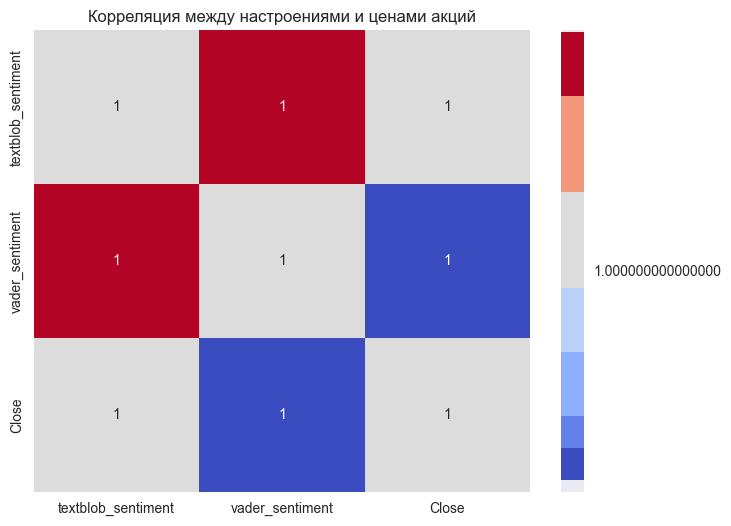

In [59]:
# Визуализация корреляции
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[['textblob_sentiment', 'vader_sentiment', 'Close']].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция между настроениями и ценами акций')
plt.show()
